## Expert Knowledge Worker

### A question answering agent that is an expert knowledge worker
### To be used by employees of Insurellm, an Insurance Tech company
### The agent needs to be accurate and the solution should be low cost.

This project will use RAG (Retrieval Augmented Generation) to ensure our question/answering assistant has high accuracy.

## TODAY:

- Part A: We will divide our documents into CHUNKS
- Part B: We will encode our CHUNKS into VECTORS and put in Chroma
- Part C: We will visualize our vectors

In [2]:
pip install langchain-huggingface

Note: you may need to restart the kernel to use updated packages.


### PART A: Divide our documents into chunks

In [1]:
import os
import glob
import tiktoken
import numpy as np
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [2]:
# price is a factor for our company, so we're going to use a low cost model

MODEL = "gpt-5-nano"
db_name = "vector_db"
load_dotenv(override=True)
openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")


OpenAI API Key exists and begins sk-proj-


In [3]:
# How many characters in all the documents?

knowledge_base_path = "knowledge-base/**/*.md"
files = glob.glob(knowledge_base_path, recursive=True)
print(f"Found {len(files)} files in the knowledge base")

entire_knowledge_base = ""

for file_path in files:
    with open(file_path, 'r', encoding='utf-8') as f:
        entire_knowledge_base += f.read()
        entire_knowledge_base += "\n\n"

print(f"Total characters in knowledge base: {len(entire_knowledge_base):,}")

Found 76 files in the knowledge base
Total characters in knowledge base: 304,434


In [4]:
# How many tokens in all the documents?

encoding = tiktoken.encoding_for_model(MODEL)
tokens = encoding.encode(entire_knowledge_base)
token_count = len(tokens)
print(f"Total tokens for {MODEL}: {token_count:,}")

Total tokens for gpt-5-nano: 63,555


In [5]:
# Load in everything in the knowledgebase using LangChain's loaders

folders = glob.glob("knowledge-base/*")

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs={'encoding': 'utf-8'})
    folder_docs = loader.load()
    for doc in folder_docs:
        doc.metadata["doc_type"] = doc_type
        documents.append(doc)

print(f"Loaded {len(documents)} documents")

Loaded 76 documents


In [6]:
documents[1]

Document(metadata={'source': 'knowledge-base\\company\\careers.md', 'doc_type': 'company'}, page_content="# Careers at Insurellm\n\n## Why Join Insurellm?\n\nAt Insurellm, we're not just building software—we're revolutionizing an entire industry. Since our founding in 2015, we've evolved from a high-growth startup to a lean, profitable company with 32 highly talented employees managing 32 active contracts across all eight of our product lines.\n\nAfter reaching 200 employees in 2020, we strategically restructured in 2022-2023 to focus on sustainable growth, operational excellence, and building a world-class remote-first culture. Today, we're a tight-knit team of exceptional professionals who deliver outsized impact through automation, AI, and strategic focus on high-value enterprise clients—from regional insurers to global reinsurance partners.\n\n### Our Culture\n\nWe live by our core values every day:\n- **Innovation First**: We encourage experimentation and creative problem-solving\

In [9]:
# Divide into chunks using the RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

print(f"Divided into {len(chunks)} chunks")
print(f"First chunk:\n\n{chunks[0]}")

Divided into 413 chunks
First chunk:

page_content='# About Insurellm

Insurellm was founded by Avery Lancaster in 2015 as an insurance tech startup designed to disrupt an industry in need of innovative products. Its first product was Markellm, the marketplace connecting consumers with insurance providers.

The company experienced rapid growth in its first five years, expanding its product portfolio to include Carllm (auto insurance portal), Homellm (home insurance portal), and Rellm (enterprise reinsurance platform). By 2020, Insurellm had reached a peak of 200 employees with 12 offices across the US.' metadata={'source': 'knowledge-base\\company\\about.md', 'doc_type': 'company'}


In [8]:
chunks[100]

Document(metadata={'source': 'knowledge-base\\contracts\\Contract with GlobalRe Partners for Rellm.md', 'doc_type': 'contracts'}, page_content='13. **Climate Risk Analytics:** Forward-looking climate modeling:\n    - IPCC climate scenario analysis (RCP 2.6, 4.5, 8.5)\n    - Transition risk assessment\n    - Physical risk modeling for perils (hurricane, wildfire, flood, drought)\n    - Sea level rise impact analysis\n    - Temperature trend incorporation\n    - Climate-adjusted pricing recommendations\n    - Stranded asset identification\n    - Green reinsurance opportunities\n\n---\n\n## Support\n\nInsurellm commits to comprehensive Enterprise-level support for GlobalRe Partners:\n\n1. **Dedicated Success Team:**\n   - Executive sponsor (CEO-level) with quarterly strategic reviews\n   - Dedicated Senior Vice President of Customer Success with bi-weekly engagement\n   - Technical Account Manager for platform optimization\n   - Solutions Architect team (2 FTE) for strategic initiatives\n

In [15]:
doc_types =set(chunk.metadata['doc_type'] for chunk in chunks)
print(f"Document types found: {' , '.join(doc_types)}")
               

Document types found: contracts , company , products , employees


In [16]:
for chunk in chunks:
    if 'Lancaster' in chunk.page_content:
        print(chunk)
        print("__________")

page_content='# About Insurellm

Insurellm was founded by Avery Lancaster in 2015 as an insurance tech startup designed to disrupt an industry in need of innovative products. Its first product was Markellm, the marketplace connecting consumers with insurance providers.

The company experienced rapid growth in its first five years, expanding its product portfolio to include Carllm (auto insurance portal), Homellm (home insurance portal), and Rellm (enterprise reinsurance platform). By 2020, Insurellm had reached a peak of 200 employees with 12 offices across the US.' metadata={'source': 'knowledge-base\\company\\about.md', 'doc_type': 'company'}
__________
page_content='# Avery Lancaster

## Summary
- **Date of Birth**: March 15, 1985
- **Job Title**: Co-Founder & Chief Executive Officer (CEO)
- **Location**: San Francisco, California
- **Current Salary**: $225,000  

## Insurellm Career Progression
- **2015 - Present**: Co-Founder & CEO  
  Avery Lancaster co-founded Insurellm in 2015 

### PART B: Make vectors and store in Chroma

In Week 3, you set up a Hugging Face account and got an HF_TOKEN

At this point, you might want to add it to your `.env` file and run `load_dotenv(override=True)`

(This actually shouldn't be required).

In [10]:
# Pick an embedding model

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
#embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 22592762-18a8-4f54-acef-35dad2ad2748)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].


Vectorstore created with 413 documents


In [13]:
# Let's investigate the vectors

collection = vectorstore._collection
count = collection.count()

sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")

There are 413 vectors with 384 dimensions in the vector store


### Part C: Visualize!

In [14]:
# Prework

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']
doc_types = [metadata['doc_type'] for metadata in metadatas]
colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]

C:\Users\Lenovo\anaconda3\envs\llms\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


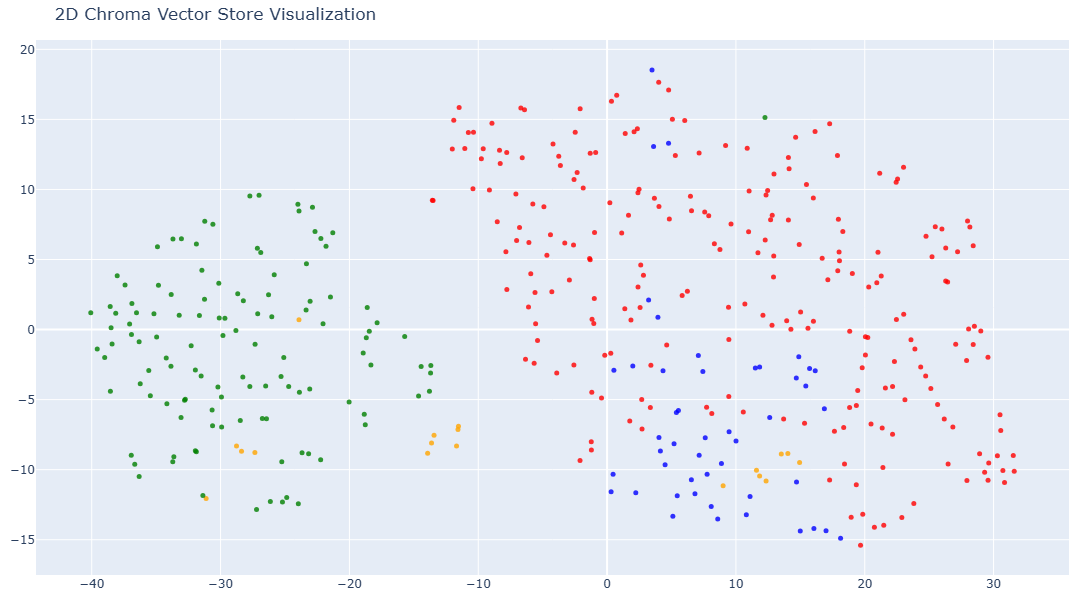

In [14]:
# We humans find it easier to visalize things in 2D!
# Reduce the dimensionality of the vectors to 2D using t-SNE
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

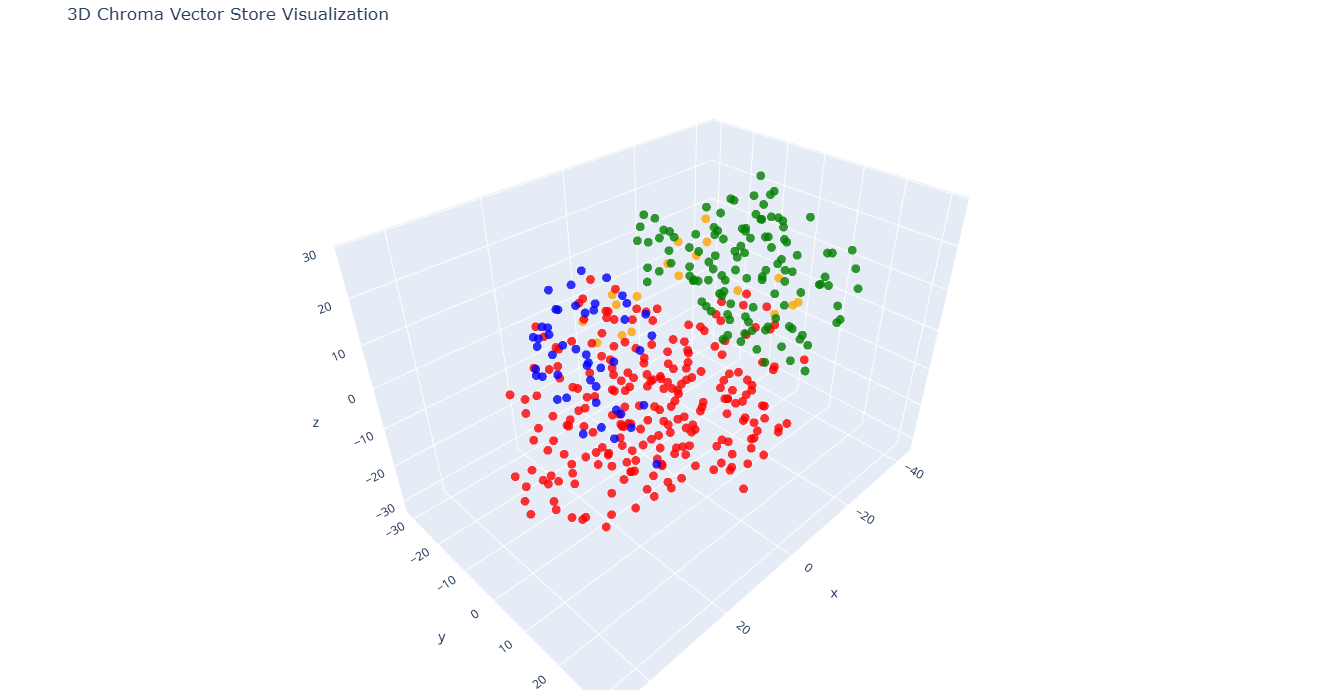

In [15]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=10, b=10, l=10, t=40)
)

fig.show()